In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,dfflagtrain,dfflagvalid,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [4]:
df.shape

(100836, 19)

In [5]:
df.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,seqNum,maxSeqNum,time_dstype,user_idx,movie_idx,dstype_random_train,dstype_time_train,dstype_random_valid,dstype_time_valid
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,1,232,train,1,1,1,1,0,0
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,2,232,train,1,2,1,1,0,0
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,3,232,train,1,3,1,1,0,0
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,4,232,train,1,4,1,1,0,0
4,1,2018,5.0,2000-07-30 18:08:43,Bambi (1942),Animation|Children|Drama,34492,3170.0,NaN,test,5,232,train,1,5,0,1,1,0


In [6]:
df_train=df.loc[df['random_dstype']=='train']
df_valid=df.loc[df['random_dstype']!='train']

In [7]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,seqNum,maxSeqNum,time_dstype,user_idx,movie_idx,dstype_random_train,dstype_time_train,dstype_random_valid,dstype_time_valid
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,1,232,train,1,1,1,1,0,0
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,2,232,train,1,2,1,1,0,0
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,3,232,train,1,3,1,1,0,0
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,4,232,train,1,4,1,1,0,0
5,1,3578,5.0,2000-07-30 18:11:08,Gladiator (2000),Action|Adventure|Drama,172495,98.0,NaN,train,6,232,train,1,6,1,1,0,0


### Add the autoencoder features

In [8]:
import pickle

In [9]:
[df_train_user_autoenc,df_valid_user_autoenc,user_mtx_1_weights,user_mtx_2_weights]=\
    pickle.load(open(f'{DATAPATH}/inter/user_autoenc_weights.pkl','rb'))

In [10]:
[df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights]=\
    pickle.load(open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','rb'))

In [11]:
df_train_user_autoenc.shape, type(df_train_user_autoenc),df_train_user_autoenc.head()

((610, 11),
 pandas.core.frame.DataFrame,
    userId  user_autoenc0  user_autoenc1  user_autoenc2  user_autoenc3  \
 0       1       0.994336       0.999980      -0.646262       0.223926   
 1       2      -0.088481       0.999484       0.794847      -0.946945   
 2       3      -0.566958       0.952057       0.952489      -0.943459   
 3       4       0.999120       0.999999      -0.135773      -0.063956   
 4       5       0.999636       0.999991      -0.693822      -0.668214   
 
    user_autoenc4  user_autoenc5  user_autoenc6  user_autoenc7  user_autoenc8  \
 0      -0.999948       0.213225      -0.953209      -0.915922       0.621617   
 1      -0.999845      -0.941635       0.934542       0.857711      -0.906707   
 2      -0.999897       0.887478      -0.806028       0.478602       0.914629   
 3      -0.997301      -0.617822      -0.995407      -0.987608      -0.491962   
 4      -0.999933      -0.847570      -0.357790      -0.943933      -0.742645   
 
    user_autoenc9  
 0  

In [12]:
df_train_item_autoenc.shape, type(df_train_item_autoenc),df_train_item_autoenc.head()

((9724, 11),
 pandas.core.frame.DataFrame,
    movieId  item_autoenc0  item_autoenc1  item_autoenc2  item_autoenc3  \
 0        1       0.985727      -0.999939      -1.000000       0.985725   
 1        2       0.988515      -0.999906      -1.000000      -0.983314   
 2        3       0.997035      -0.999920      -1.000000      -0.999982   
 3        4       0.975186      -0.998372      -0.999998      -0.996532   
 4        5       0.995001      -0.999872      -1.000000      -0.998066   
 
    item_autoenc4  item_autoenc5  item_autoenc6  item_autoenc7  item_autoenc8  \
 0       0.999361       0.978994       1.000000       0.997096      -0.999999   
 1      -0.245007      -0.976791       0.999660       0.994780      -0.999883   
 2      -0.991933      -0.999966       0.996191       0.995884      -0.908520   
 3      -0.996155      -0.999894       0.958139       0.995000      -0.435840   
 4      -0.719084      -0.998945       0.999637       0.996154      -0.945519   
 
    item_autoenc9

In [13]:
df_train.shape

(90752, 19)

In [14]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,seqNum,maxSeqNum,time_dstype,user_idx,movie_idx,dstype_random_train,dstype_time_train,dstype_random_valid,dstype_time_valid
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,1,232,train,1,1,1,1,0,0
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,2,232,train,1,2,1,1,0,0
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,3,232,train,1,3,1,1,0,0
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,4,232,train,1,4,1,1,0,0
5,1,3578,5.0,2000-07-30 18:11:08,Gladiator (2000),Action|Adventure|Drama,172495,98.0,NaN,train,6,232,train,1,6,1,1,0,0


In [15]:
df_train=pd.merge(df_train,df_train_item_autoenc,on='movieId',how='left')

In [16]:
df_train.shape

(90752, 29)

In [17]:
print(df_valid.shape)
df_valid=pd.merge(df_valid,df_valid_item_autoenc,on='movieId',how='left')
df_valid.shape

(10084, 19)


(10084, 29)

In [18]:
df_valid.shape

(10084, 29)

In [19]:
print(df_valid.shape)
df_valid=pd.merge(df_valid,df_valid_user_autoenc,on='userId',how='left')
df_valid.shape

(10084, 29)


(10084, 39)

In [20]:
print(df_train.shape)
df_train=pd.merge(df_train,df_train_user_autoenc,on='userId',how='left')
df_train.shape

(90752, 29)


(90752, 39)

In [21]:
df_train.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId', 'tag', 'random_dstype', 'seqNum', 'maxSeqNum', 'time_dstype',
       'user_idx', 'movie_idx', 'dstype_random_train', 'dstype_time_train',
       'dstype_random_valid', 'dstype_time_valid', 'item_autoenc0',
       'item_autoenc1', 'item_autoenc2', 'item_autoenc3', 'item_autoenc4',
       'item_autoenc5', 'item_autoenc6', 'item_autoenc7', 'item_autoenc8',
       'item_autoenc9', 'user_autoenc0', 'user_autoenc1', 'user_autoenc2',
       'user_autoenc3', 'user_autoenc4', 'user_autoenc5', 'user_autoenc6',
       'user_autoenc7', 'user_autoenc8', 'user_autoenc9'],
      dtype='object')

In [22]:
autoenc_cols=df_train.columns[df_train.columns.str.contains('autoenc')]

In [23]:
autoenc_cols=autoenc_cols.tolist()

In [24]:
autoenc_cols

['item_autoenc0',
 'item_autoenc1',
 'item_autoenc2',
 'item_autoenc3',
 'item_autoenc4',
 'item_autoenc5',
 'item_autoenc6',
 'item_autoenc7',
 'item_autoenc8',
 'item_autoenc9',
 'user_autoenc0',
 'user_autoenc1',
 'user_autoenc2',
 'user_autoenc3',
 'user_autoenc4',
 'user_autoenc5',
 'user_autoenc6',
 'user_autoenc7',
 'user_autoenc8',
 'user_autoenc9']

In [25]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,...,user_autoenc0,user_autoenc1,user_autoenc2,user_autoenc3,user_autoenc4,user_autoenc5,user_autoenc6,user_autoenc7,user_autoenc8,user_autoenc9
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871
4,1,3578,5.0,2000-07-30 18:11:08,Gladiator (2000),Action|Adventure|Drama,172495,98.0,NaN,train,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871


In [26]:
df_train[['user_idx','movie_idx']+autoenc_cols].head()

,user_idx,movie_idx,item_autoenc0,item_autoenc1,item_autoenc2,item_autoenc3,item_autoenc4,item_autoenc5,item_autoenc6,item_autoenc7,...,user_autoenc0,user_autoenc1,user_autoenc2,user_autoenc3,user_autoenc4,user_autoenc5,user_autoenc6,user_autoenc7,user_autoenc8,user_autoenc9
0,1,1,0.988670,-0.999911,-0.999998,0.995292,0.998766,0.976307,1.000000,0.997302,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871
1,1,2,0.990869,-0.999912,-0.999999,-0.761764,-0.986719,-0.995782,0.999659,0.998968,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871
2,1,3,0.994971,-0.999953,-1.000000,-0.622540,0.909488,-0.464001,0.999998,0.998657,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871
3,1,4,0.987776,-0.999880,-0.999997,0.515767,0.964464,0.743508,1.000000,0.997565,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871
4,1,6,0.993171,-0.999977,-1.000000,0.994922,0.997613,0.981797,1.000000,0.999067,...,0.994336,0.99998,-0.646262,0.223926,-0.999948,0.213225,-0.953209,-0.915922,0.621617,-0.999871


### Dataset and DataLoader

In [27]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [28]:
dstrain=cfdata(df_train[['user_idx','movie_idx']+autoenc_cols],df_train['rating'],autoenc_cols)
dsvalid=cfdata(df_valid[['user_idx','movie_idx']+autoenc_cols],df_valid['rating'],autoenc_cols)

In [29]:
df_train.shape

(90752, 39)

In [30]:
bs=8

In [31]:
dltrain=DataLoader(dstrain,bs,True)

In [32]:
dlvalid=DataLoader(dsvalid,bs,True)

## Model Architecture

In [33]:
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=10
n_emb_movie=25
min_rating=min(df_train['rating'])
max_rating=max(df_train['rating'])
dropout_e=0.05
hidden=[25,10]
dropouts=[0.2,0.2]

In [34]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [35]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,\
                 dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2]):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_movie,self.n_movies,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.create_architecture()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_movie=nn.Embedding(self.n_movies+1,self.n_emb_movie)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        
        lins=[hidden_layer(self.n_emb_user+self.n_emb_movie+self.len_dense_cols if i==0 else self.hidden[i-1],\
                                self.hidden[i] if i <len(hidden) else 1,
                                self.dropouts[i] if i < len(hidden) else 0,
                                nn.ReLU()) for i in range(len(hidden)+1)]
        self.lins=nn.Sequential(*lins)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_movie.weight.dat)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_movie(items))
        denses=Xb[:,2:]
        embed=torch.cat([users,items,denses],1)
        out=self.lins(embed)
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [36]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)

In [37]:
cfobj

cf(
  (emb_user): Embedding(611, 10)
  (emb_movie): Embedding(9725, 25)
  (emb_dropout): Dropout(p=0.05)
  (lins): Sequential(
    (0): Sequential(
      (0): Linear(in_features=55, out_features=25, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
    )
  )
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [38]:
for Xb, Yb in dltrain:
    break

In [39]:
Xb.shape, Yb.shape

(torch.Size([8, 22]), torch.Size([8, 1]))

In [40]:
Xb.dtype

torch.float32

In [41]:
cfobj.forward(Xb,Yb)

(tensor([[2.9768],
         [2.9168],
         [2.9805],
         [2.8909],
         [2.8948],
         [2.8267],
         [2.8998],
         [2.9882]], grad_fn=<AddBackward0>),
 tensor(0.9316, grad_fn=<MseLossBackward>))

## Learner

In [42]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

        with torch.no_grad():
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
        acc=np.sqrt(myloss)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            
            epoch_loss+=loss
            epoch_acc+=acc
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
            
        return epoch_loss,epoch_acc
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc=self.run_epoch(dltrain,True)
            lossv,accv=self.run_epoch(dlvalid,mode_train=False)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{acc} Valid RMSE:{accv}')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [43]:
device='cuda:0'

In [44]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)

In [45]:
cfobj=cfobj.to(device)

In [46]:
cfobj

cf(
  (emb_user): Embedding(611, 10)
  (emb_movie): Embedding(9725, 25)
  (emb_dropout): Dropout(p=0.05)
  (lins): Sequential(
    (0): Sequential(
      (0): Linear(in_features=55, out_features=25, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
    )
  )
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [47]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [48]:
len(dltrain)

11344

In [49]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

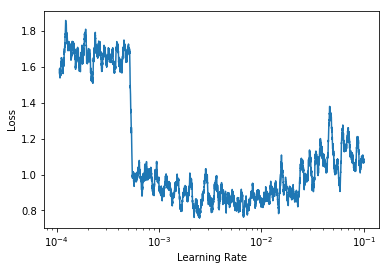

In [53]:
learner.plot_lrs(100)

In [54]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-4,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [55]:
del cfobj
torch.cuda.empty_cache()

In [56]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)
cfobj=cfobj.to(device)

In [ ]:
learner.run_epochs(dltrain,dlvalid,25)

Epoch:0 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:1.0761382262805694                 Valid Loss:1.0970779667762798 Train RMSE:1.0043395410755496 Valid RMSE:1.0136727380638075
Epoch:1 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:1.0394278097045917                 Valid Loss:1.0180971665657956 Train RMSE:0.9843017430826017 Valid RMSE:0.9728491203134938
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.9123775121105352                 Valid Loss:0.9231424140260155 Train RMSE:0.9179331667960511 Valid RMSE:0.9269209634962571
Epoch:3 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.8334544894068104                 Valid Loss:0.8872773922052202 Train RMSE:0.8754486902681499 Valid RMSE:0.9074387361013597
Epoch:4 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.8039175832433276                 Valid Loss:0.8718824779273592 Train RMSE:0.859899014792548 Valid RMSE:0.8964642156200826
Epoch:5 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.7869242659260286    

In [151]:
del cfobj
torch.cuda.empty_cache()

In [152]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)
cfobj=cfobj.to(device)

In [153]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=8e-3,end_lr=8e-4)

In [154]:
learner.run_epochs(dltrain,dlvalid,20)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.843544218016326                 Valid Loss:0.8981637894800029 Train RMSE:0.8810616715046327 Valid RMSE:0.9123333699528205
Epoch:1 Learning rate 0.002 Weight Decay 1e-07 Train Loss:0.7616456080574874                 Valid Loss:0.8694652731838347 Train RMSE:0.8347994758886323 Valid RMSE:0.8977518560149601
Epoch:2 Learning rate 0.0008 Weight Decay 1e-07 Train Loss:0.7314371012308213                 Valid Loss:0.869653258245205 Train RMSE:0.817331555922132 Valid RMSE:0.8966047095573153
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.7710638780406924                 Valid Loss:0.8848729260283552 Train RMSE:0.8408356648867297 Valid RMSE:0.9043134218701291
Epoch:4 Learning rate 0.0031622776601683794 Weight Decay 1e-07 Train Loss:0.7464543257075479                 Valid Loss:0.9129999140713254 Train RMSE:0.8266364040472902 Valid RMSE:0.9187421742830725
Epoch:5 Learning rate 0.002 Weight Decay 1e-07 Train Loss:0.72386207182

In [172]:

torch.save(cfobj,f'{DATAPATH}/inter/cfobj')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [177]:
torch.save(optimizer,f'{DATAPATH}/inter/optimizer')

In [183]:
pickle.dump(learner,open(f'{DATAPATH}/inter/learner','wb'))

PicklingError: Can't pickle <class '__main__.Learner'>: it's not the same object as __main__.Learner